In [1]:
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
import string
from nltk.util import ngrams
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk

feature engineering: polarity and subjectivity

Polarity: numerical score that quantifies the sentiment of the text on a continuous scale. It measures how positive or negative the text is. Polarity scores typically range from -1 (extremely negative) to 1 (extremely positive), with 0 indicating neutral sentiment.

Subjectivity: Subjectivity measures the degree to which the text is subjective or opinion-based rather than objective. Subjectivity is also represented as a numerical score ranging from 0 to 1. A score closer to 0 suggests that the text is more objective, factual, or informational. A score closer to 1 suggests that the text is more subjective and opinion-based.

In [2]:
df = pd.read_csv('Preprocessed_data.csv')

/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_86926/3893856730.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Preprocessed_data.csv')


In [3]:
df.head()

,Unnamed: 0,reviewDate,reviewID,reviewerID,reviewContent,reviewRating,reviewUsefulCount,reviewCoolCount,reviewFunnyCount,restaurantID,...,reviewDate2,date_diff_joinedandreviewed,word_count,char_count,tokens,clean_tokens,clean_text,ngrams,preprocessed,main_topic
0,0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,"Unlike Next, which we'd eaten at the previous ...",5,0,0,0,pbEiXam9YJL3neCYHGwLUA,...,2012-09-22,1087,871,4890,"['Unlike', 'Next', ',', 'which', 'we', ""'"", 'd...","['unlike', 'next', 'eaten', 'previous', 'night...",unlike next eaten previous night dish complete...,"[('unlike', 'next'), ('next', 'eaten'), ('eate...","['unlike', 'next', 'wed', 'eaten', 'previous',...",33
1,1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,Probably one of the best meals I've had ever. ...,5,0,0,0,pbEiXam9YJL3neCYHGwLUA,...,2012-09-22,479,66,350,"['Probably', 'one', 'of', 'the', 'best', 'meal...","['probably', 'one', 'best', 'meals', 'ever', '...",probably one best meals ever performance food ...,"[('probably', 'one'), ('one', 'best'), ('best'...","['probably', 'one', 'best', 'meal', 'ive', 'ev...",10
2,2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,Service was impeccable. Experience and present...,3,2,0,0,pbEiXam9YJL3neCYHGwLUA,...,2012-09-19,1479,45,257,"['Service', 'was', 'impeccable', '.', 'Experie...","['service', 'impeccable', 'experience', 'prese...",service impeccable experience presentation coo...,"[('service', 'impeccable'), ('impeccable', 'ex...","['service', 'impeccable', 'experience', 'prese...",18
3,3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,"The problem with places like this, given the e...",3,8,0,3,pbEiXam9YJL3neCYHGwLUA,...,2012-09-06,1802,358,2156,"['The', 'problem', 'with', 'places', 'like', '...","['problem', 'places', 'like', 'given', 'exhorb...",problem places like given exhorbitant cost med...,"[('problem', 'places'), ('places', 'like'), ('...","['problem', 'place', 'like', 'given', 'exhorbi...",33
4,4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,I have no idea how to write my review - dining...,5,1,2,0,pbEiXam9YJL3neCYHGwLUA,...,2012-09-09,1897,172,951,"['I', 'have', 'no', 'idea', 'how', 'to', 'writ...","['idea', 'write', 'review', 'dining', 'alinea'...",idea write review dining alinea brings whole d...,"[('idea', 'write'), ('write', 'review'), ('rev...","['idea', 'write', 'review', 'dining', 'alinea'...",33


### Number of Characters of reviewContent (Num_Chars)

##### From our earlier analysis, we would be adding a new column `Num_Char` which is the total number of characters in the reviewContent

In [4]:
df["Num_Char"] = df["reviewContent"].apply(lambda x: len(x))

### Number of Punctuations of reviewContent (Num_Punc)

##### From our earlier analysis, we would be adding a new column `NUm_Punc` which is the total number of punctuations in the reviewContent

In [5]:
def punctuation_count(text):
    return Counter(char for char in text if char in string.punctuation)
total_punc = df["reviewContent"].apply(punctuation_count)
df["Num_Punc"] = total_punc.apply(lambda x: sum(x.values()))


### POS Tagging - Adding Num_Verb and Num_Adj

In [6]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

def count_pos(text):
    #tokenize into words 
    words = word_tokenize(text)

    # pos for each word 
    pos_tags = nltk.pos_tag(words)

    tags = [tag for word, tag in pos_tags]

    tag_freq = Counter(tags)

    return pd.Series({
        'verb_count': sum(freq for tag, freq in tag_freq.items() if tag.startswith('VB')),
        'adj_count': sum(freq for tag, freq in tag_freq.items() if tag.startswith('JJ'))
    })


In [8]:
pos_counts = df["reviewContent"].apply(count_pos)
df = pd.concat([df, pos_counts],axis=1)

In [9]:
df.head()

,Unnamed: 0,reviewDate,reviewID,reviewerID,reviewContent,reviewRating,reviewUsefulCount,reviewCoolCount,reviewFunnyCount,restaurantID,...,tokens,clean_tokens,clean_text,ngrams,preprocessed,main_topic,Num_Char,Num_Punc,verb_count,adj_count
0,0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,"Unlike Next, which we'd eaten at the previous ...",5,0,0,0,pbEiXam9YJL3neCYHGwLUA,...,"['Unlike', 'Next', ',', 'which', 'we', ""'"", 'd...","['unlike', 'next', 'eaten', 'previous', 'night...",unlike next eaten previous night dish complete...,"[('unlike', 'next'), ('next', 'eaten'), ('eate...","['unlike', 'next', 'wed', 'eaten', 'previous',...",33,4890,143,170,50
1,1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,Probably one of the best meals I've had ever. ...,5,0,0,0,pbEiXam9YJL3neCYHGwLUA,...,"['Probably', 'one', 'of', 'the', 'best', 'meal...","['probably', 'one', 'best', 'meals', 'ever', '...",probably one best meals ever performance food ...,"[('probably', 'one'), ('one', 'best'), ('best'...","['probably', 'one', 'best', 'meal', 'ive', 'ev...",10,350,10,15,8
2,2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,Service was impeccable. Experience and present...,3,2,0,0,pbEiXam9YJL3neCYHGwLUA,...,"['Service', 'was', 'impeccable', '.', 'Experie...","['service', 'impeccable', 'experience', 'prese...",service impeccable experience presentation coo...,"[('service', 'impeccable'), ('impeccable', 'ex...","['service', 'impeccable', 'experience', 'prese...",18,257,9,14,5
3,3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,"The problem with places like this, given the e...",3,8,0,3,pbEiXam9YJL3neCYHGwLUA,...,"['The', 'problem', 'with', 'places', 'like', '...","['problem', 'places', 'like', 'given', 'exhorb...",problem places like given exhorbitant cost med...,"[('problem', 'places'), ('places', 'like'), ('...","['problem', 'place', 'like', 'given', 'exhorbi...",33,2156,84,52,34
4,4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,I have no idea how to write my review - dining...,5,1,2,0,pbEiXam9YJL3neCYHGwLUA,...,"['I', 'have', 'no', 'idea', 'how', 'to', 'writ...","['idea', 'write', 'review', 'dining', 'alinea'...",idea write review dining alinea brings whole d...,"[('idea', 'write'), ('write', 'review'), ('rev...","['idea', 'write', 'review', 'dining', 'alinea'...",33,951,29,27,20


In [18]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob

# Tokenization
tokenizer = WordPunctTokenizer()
df['tokens'] = df['reviewContent'].apply(tokenizer.tokenize)

# Define a function to remove stopwords and punctuation
def preprocess_text(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens]  # Convert to lowercase
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [word for word in tokens if word not in string.punctuation]  # Remove punctuation
    tokens = [word for word in tokens if len(word) > 1]  # Remove single-character words
    return tokens

# Apply preprocessing to the 'tokens' column
df['clean_tokens'] = df['tokens'].apply(preprocess_text)

# Join the clean tokens back into sentences
df['clean_text'] = df['clean_tokens'].apply(lambda x: ' '.join(x))

# Sentiment Analysis using TextBlob
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment)

# Extract polarity and subjectivity scores from the sentiment analysis
df['polarity'] = df['sentiment'].apply(lambda x: x.polarity)
df['subjectivity'] = df['sentiment'].apply(lambda x: x.subjectivity)


##### Summer - idk why the code below is not working alone, bc prior to running this we already have the columns clean_text and clean_tokens and these columns were created in the preprocessing file 

In [ ]:
# # Tokenization
# tokenizer = WordPunctTokenizer()

# # Sentiment Analysis using TextBlob
# df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment)

# # Extract polarity and subjectivity scores from the sentiment analysis
# df['polarity'] = df['sentiment'].apply(lambda x: x.polarity)
# df['subjectivity'] = df['sentiment'].apply(lambda x: x.subjectivity)

In [29]:
df.head()

,Unnamed: 0,reviewDate,reviewID,reviewerID,reviewContent,reviewRating,reviewUsefulCount,reviewCoolCount,reviewFunnyCount,restaurantID,...,ngrams,preprocessed,main_topic,Num_Char,Num_Punc,verb_count,adj_count,sentiment,polarity,subjectivity
0,0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,"Unlike Next, which we'd eaten at the previous ...",5,0,0,0,pbEiXam9YJL3neCYHGwLUA,...,"[('unlike', 'next'), ('next', 'eaten'), ('eate...","['unlike', 'next', 'wed', 'eaten', 'previous',...",33,4890,143,170,50,"(0.13913951545530495, 0.5286549707602339)",0.139140,0.528655
1,1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,Probably one of the best meals I've had ever. ...,5,0,0,0,pbEiXam9YJL3neCYHGwLUA,...,"[('probably', 'one'), ('one', 'best'), ('best'...","['probably', 'one', 'best', 'meal', 'ive', 'ev...",10,350,10,15,8,"(0.4666666666666666, 0.5666666666666667)",0.466667,0.566667
2,2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,Service was impeccable. Experience and present...,3,2,0,0,pbEiXam9YJL3neCYHGwLUA,...,"[('service', 'impeccable'), ('impeccable', 'ex...","['service', 'impeccable', 'experience', 'prese...",18,257,9,14,5,"(0.4133333333333334, 0.72)",0.413333,0.720000
3,3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,"The problem with places like this, given the e...",3,8,0,3,pbEiXam9YJL3neCYHGwLUA,...,"[('problem', 'places'), ('places', 'like'), ('...","['problem', 'place', 'like', 'given', 'exhorbi...",33,2156,84,52,34,"(0.12054824561403507, 0.5352005012531328)",0.120548,0.535201
4,4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,I have no idea how to write my review - dining...,5,1,2,0,pbEiXam9YJL3neCYHGwLUA,...,"[('idea', 'write'), ('write', 'review'), ('rev...","['idea', 'write', 'review', 'dining', 'alinea'...",33,951,29,27,20,"(0.16746031746031745, 0.5646825396825398)",0.167460,0.564683


In [30]:
df.to_csv("Engineered.csv")

## BERT Model

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import re 

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from ast import literal_eval
import matplotlib.pyplot as plt

In [ ]:
# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
df = df.dropna(subset=['reviewContent'])

In [ ]:
def embed_text_in_row(row, tokenizer, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Extract text from the row
    text = row['reviewContent']  # Replace 'text_column' with the actual column name containing text

    # Tokenize input text
    tokenized_text = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

    # Move input tensors to the specified device
    input_ids = tokenized_text['input_ids'].to(device)
    attention_mask = tokenized_text['attention_mask'].to(device)

    # Move the model to the specified device
    model = model.to(device)

    # Generate embeddings
    with torch.no_grad():
        embeddings = model(input_ids, attention_mask=attention_mask)

    # Extract embeddings from the output
    vector_embedding = embeddings.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    # Convert numpy array to a list
    list_embedding = vector_embedding.tolist()

    return str(list_embedding)

In [ ]:
df['embedding'] = None

In [ ]:
df['embedding'] = df['reviewContent'].apply(lambda x: embed_text_in_row({'reviewContent': x}, tokenizer, model))

In [ ]:
df_embeddings = df[['reviewID','embedding']]

In [ ]:
df_embeddings.to_csv('embeddings.csv', index=False)

In [ ]:
matrix = np.array(df_embeddings.embedding.apply(literal_eval).to_list())

In [ ]:
matrix

array([[-0.23913899,  0.12833293,  0.03060093, ...,  0.16468036,
         0.2161012 ,  0.16135179],
       [ 0.10993178,  0.10660127,  0.09500737, ...,  0.07056168,
         0.11085753,  0.14064667],
       [ 0.17507008,  0.03029392,  0.13392456, ..., -0.08949118,
         0.11465451,  0.25596529],
       ...,
       [ 0.09447625, -0.1751326 ,  0.07999234, ...,  0.11555438,
         0.23005812, -0.10286359],
       [ 0.2742891 , -0.14054079,  0.08639319, ...,  0.09889236,
         0.25229341,  0.04704156],
       [-0.14081946, -0.09542824,  0.37978581, ...,  0.01713007,
         0.04187828,  0.18431315]])

In [ ]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(26956, 2)

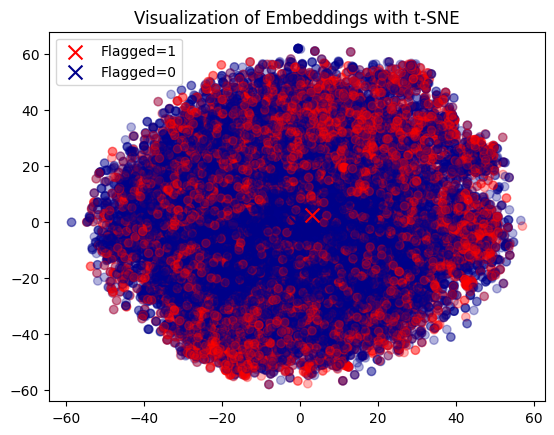

In [ ]:
colors = {1: "red", 0: "darkblue"}  # Add colors for 'y' and 'n'
x = vis_dims[:, 0]
y = vis_dims[:, 1]
color_indices = [colors[flag] for flag in df.flagged]

plt.scatter(x, y, c=color_indices, alpha=0.3)

# Plot average points for each 'Flagged' value
for flag in [1, 0]:
    avg_x = np.mean(x[df.flagged == flag])
    avg_y = np.mean(y[df.flagged == flag])
    color = colors[flag]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100, label=f'Flagged={flag}')

plt.title("Visualization of Embeddings with t-SNE")
plt.legend()
plt.show()

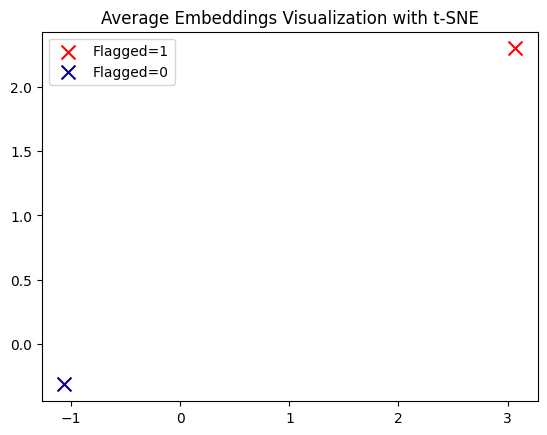

In [ ]:
for flag in [1, 0]:
    avg_x = np.mean(x[df.flagged == flag])
    avg_y = np.mean(y[df.flagged == flag])
    color = colors[flag]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100, label=f'Flagged={flag}')

plt.title("Average Embeddings Visualization with t-SNE")
plt.legend()
plt.show()

### Instantiate Model 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt', max_length=512, truncation=True)
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
df["bert_sentiment"] = df["reviewContent"].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
df["bert_sentiment"].value_counts()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'bert_sentiment' and 'class'

# Create separate histograms for fraud and non-fraud classes
plt.figure(figsize=(10, 6))

# Histogram for the "bert_sentiment" of the fraud class
sns.histplot(data=df[df['flagged'] == "Y"], x='bert_sentiment', kde=True, color='red', label='Fraud')

# Histogram for the "bert_sentiment" of the non-fraud class
sns.histplot(data=df[df['flagged'] == 'N'], x='bert_sentiment', kde=True, color='blue', label='Non-Fraud')

plt.title('Distribution of BERT Sentiment Scores')
plt.xlabel('BERT Sentiment')
plt.ylabel('Frequency')
plt.legend()

# Set the x-axis limits to be between 1 and 5
plt.xlim(1, 5)

plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(df[df["flagged"]=="N"]["bert_sentiment"], shade=True, color="green", label="Genuine", ax=ax)

sns.kdeplot(df[df["flagged"]=="Y"]["bert_sentiment"], shade=True, color="blue", label="Fraudulent", ax=ax)
ax.set_xlabel("Sentiment Score ")
ax.set_ylabel("Density")
ax.legend()
fig.suptitle("Sentiment Value vs Fraud Class")

In [ ]:
df_bert = pd.DataFrame({
    'id': range(len(df)),
    'label': df['flagged'],
    'alpha': ['a']*df.shape[0],
    'text': df['reviewContent'].replace(r'\n', ' ', regex=True)
})
# Splitting training data file into *train* and *dev*
df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.01)

df_bert_train.head()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(df_bert_train['text'].tolist(), truncation=True, padding=True, max_length=128)
dev_encodings = tokenizer(df_bert_dev['text'].tolist(), truncation=True, padding=True, max_length=128)

# Create a Dataset class
import torch
from torch.utils.data import Dataset

class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, df_bert_train['label'].tolist())
dev_dataset = ReviewsDataset(dev_encodings, df_bert_dev['label'].tolist())

# Model and training setup
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
    do_eval=True,
    output_dir='./results',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)

# Fine-tune the model
trainer.train()